In [25]:
#importing all necessary library
import pandas as pd
import json
#%matplotlib notebook
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns
# Plot missing values
#!pip install missingno
import missingno as msno

import numpy as np
from datetime import datetime, timedelta
import requests
from urllib.parse import urlencode

In the following line of code, I am importing my sleep data from Fitbit API

In [26]:
# Fitbit API credentials
CLIENT_ID = '23R3QL'
CLIENT_SECRET = 'c28da792517b5fa74146c40f8dfea620'
REDIRECT_URI = 'http://localhost:8080/callback'

# Step 1: Get authorization code
auth_url = 'https://www.fitbit.com/oauth2/authorize?' + urlencode({
    'response_type': 'code',
    'client_id': CLIENT_ID,
#     'redirect_uri': REDIRECT_URI,
    'scope': 'activity sleep profile'
})
print(f"Visit the following URL in your browser to authorize the application:\n{auth_url}")
auth_code = input("Enter the authorization code after granting access: ")

Visit the following URL in your browser to authorize the application:
https://www.fitbit.com/oauth2/authorize?response_type=code&client_id=23R3QL&scope=activity+sleep+profile
Enter the authorization code after granting access: bc2e4e2fcf10a9b293704bc81922b1c64f54c9ab


In [27]:
token_url = 'https://api.fitbit.com/oauth2/token'
token_payload = {
    'clientId': CLIENT_ID,
    'grant_type': 'authorization_code',
    'code': 'bc2e4e2fcf10a9b293704bc81922b1c64f54c9ab',
    'redirect_uri': REDIRECT_URI,
}
token_response = requests.post(token_url, auth=(CLIENT_ID, CLIENT_SECRET), data=token_payload)
token_data = token_response.json()
access_token = token_data['access_token']

In [28]:
# Define the start and end dates
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 4, 20)

# Define the interval (100 days)
interval = timedelta(days=98)

# Initialize a variable to keep track of the current date
current_date = start_date

# Define your access token (replace 'your_access_token' with your actual access token)
#access_token = 'your_access_token'

# Create an empty list to accumulate profile data
all_profile_data = []

# Create a loop to iterate through the dates
while current_date <= end_date:
    # Convert the current_date to string format
    start_date_str = current_date.strftime('%Y-%m-%d')
    end_date_str = (current_date + interval).strftime('%Y-%m-%d')

    # Construct the profile_url using the variables
    base_url = 'https://api.fitbit.com/1.2/user/-/sleep/date/'
    profile_url = f'{base_url}{start_date_str}/{end_date_str}.json'

    # Set up the headers with the access token
    profile_headers = {'Authorization': f'Bearer {access_token}'}
    
    # Make the API request to fetch profile data
    profile_response = requests.get(profile_url, headers=profile_headers)
    profile_data = profile_response.json()
    all_profile_data.append(profile_data)
    # Print the current date as a string (optional)
    print(current_date.strftime('%Y-%m-%d'))
    
    # Move to the next date by adding the interval
    current_date += interval 

2022-01-01
2022-04-09
2022-07-16
2022-10-22
2023-01-28


In [29]:
df_list = []

# Assuming you have some initialization for final_df
final_df = pd.DataFrame()

for profile_data in all_profile_data:
    sleep_data = profile_data.get('sleep', [])
    
    # Check if sleep data is not empty for this profile
    if sleep_data:
        # Create a temporary DataFrame for this profile's sleep data
        temp_df = pd.DataFrame(sleep_data)
        
        # Extract specific keys from the sleep data
        keys_to_extract = ['dateOfSleep', 'duration', 'efficiency', 'levels', 'logId', 'minutesAfterWakeup', 'minutesAsleep', 'minutesAwake', 'timeInBed']
        temp_df = temp_df[keys_to_extract]
        
        # Append the temporary DataFrame to the list
        df_list.append(temp_df)

# Concatenate all DataFrames in the list into one final DataFrame
final_dfsleep = pd.concat(df_list, ignore_index=True)

In [30]:
type(final_dfsleep)
print(final_dfsleep.shape)
final_dfsleep.head()

(496, 9)


,dateOfSleep,duration,efficiency,levels,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,timeInBed
0,2022-04-09,24840000,42,{'data': [{'dateTime': '2022-04-09T03:49:30.00...,36439426020,38,353,61,414
1,2022-04-08,28200000,41,{'data': [{'dateTime': '2022-04-08T01:48:00.00...,36427206153,6,419,51,470
2,2022-04-07,30000000,52,{'data': [{'dateTime': '2022-04-07T02:04:00.00...,36412726821,0,435,65,500
3,2022-04-06,28500000,56,{'data': [{'dateTime': '2022-04-06T02:55:30.00...,36400369490,20,422,53,475
4,2022-04-05,24660000,50,{'data': [{'dateTime': '2022-04-05T03:22:30.00...,36387494363,34,350,61,411


From above dataframe head, we can see that level column has nested value that I want to convert into a column name for easier analysis for later.

In [31]:
def level_extraction(sleep_data_df):
    summary = sleep_data_df['levels'][0]['summary']
#for key,value in summary.items():
    #df_sleep[key]= value 
    
#df_summary =pd.DataFrame()

    def extract_summary(row):
        summary = row['levels']['summary']
        for key,value in summary.items():
            row[key] = value 
        return row

    df_sleep = sleep_data_df.apply(lambda row:extract_summary(row), axis=1)

    return(df_sleep)

In [32]:
df_sleep = level_extraction(final_dfsleep)

In [33]:
df_sleep.head()

,asleep,awake,dateOfSleep,deep,duration,efficiency,levels,light,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,rem,restless,timeInBed,wake
0,NaN,NaN,2022-04-09,"{'count': 5, 'minutes': 75, 'thirtyDayAvgMinut...",24840000,42,{'data': [{'dateTime': '2022-04-09T03:49:30.00...,"{'count': 25, 'minutes': 200, 'thirtyDayAvgMin...",36439426020,38,353,61,"{'count': 7, 'minutes': 78, 'thirtyDayAvgMinut...",NaN,414,"{'count': 25, 'minutes': 61, 'thirtyDayAvgMinu..."
1,NaN,NaN,2022-04-08,"{'count': 2, 'minutes': 64, 'thirtyDayAvgMinut...",28200000,41,{'data': [{'dateTime': '2022-04-08T01:48:00.00...,"{'count': 26, 'minutes': 248, 'thirtyDayAvgMin...",36427206153,6,419,51,"{'count': 8, 'minutes': 107, 'thirtyDayAvgMinu...",NaN,470,"{'count': 23, 'minutes': 51, 'thirtyDayAvgMinu..."
2,NaN,NaN,2022-04-07,"{'count': 5, 'minutes': 80, 'thirtyDayAvgMinut...",30000000,52,{'data': [{'dateTime': '2022-04-07T02:04:00.00...,"{'count': 26, 'minutes': 225, 'thirtyDayAvgMin...",36412726821,0,435,65,"{'count': 14, 'minutes': 130, 'thirtyDayAvgMin...",NaN,500,"{'count': 24, 'minutes': 65, 'thirtyDayAvgMinu..."
3,NaN,NaN,2022-04-06,"{'count': 3, 'minutes': 73, 'thirtyDayAvgMinut...",28500000,56,{'data': [{'dateTime': '2022-04-06T02:55:30.00...,"{'count': 24, 'minutes': 237, 'thirtyDayAvgMin...",36400369490,20,422,53,"{'count': 7, 'minutes': 112, 'thirtyDayAvgMinu...",NaN,475,"{'count': 25, 'minutes': 53, 'thirtyDayAvgMinu..."
4,NaN,NaN,2022-04-05,"{'count': 3, 'minutes': 55, 'thirtyDayAvgMinut...",24660000,50,{'data': [{'dateTime': '2022-04-05T03:22:30.00...,"{'count': 28, 'minutes': 196, 'thirtyDayAvgMin...",36387494363,34,350,61,"{'count': 7, 'minutes': 99, 'thirtyDayAvgMinut...",NaN,411,"{'count': 25, 'minutes': 61, 'thirtyDayAvgMinu..."


Now I still need to extract values within the columns: deep, light, rem and wake to break down each of sleep levels value: count, number of minutes in each sleep level and what is the thirty day average value. Creating the data column for each of these value for each of sleep level in the code below.

Before extracting values in the column, we need to check for na values in this column and explore them.

In [34]:
def columns_inspect(df_sleep):
    columns_to_inspect = ['deep', 'light', 'rem', 'wake']

## This part tells how many rows have NA values in columns_to_inspect
    for col in columns_to_inspect:
        float_count = df_sleep[col].apply(lambda x: isinstance(x, float)).sum()
        print(f"Column '{col}': {float_count} rows with float data type")
    
## This part lets me explore if same columns have Nan values.     
    for col in columns_to_inspect:
        print(f"Inspecting column '{col}':")
        for index in range(len(df_sleep)):
            row_data = df_sleep[col].iloc[index]
        if not isinstance(row_data, dict):
            print(f"Row {index}: {row_data}")
    print()
    
    df_sleep.dropna(subset=columns_to_inspect, inplace=True)

    return(df_sleep)

In [35]:
df_sleep_notna = columns_inspect(df_sleep)
df_sleep_notna.head()

Column 'deep': 23 rows with float data type
Column 'light': 23 rows with float data type
Column 'rem': 23 rows with float data type
Column 'wake': 23 rows with float data type
Inspecting column 'deep':
Inspecting column 'light':
Inspecting column 'rem':
Inspecting column 'wake':



,asleep,awake,dateOfSleep,deep,duration,efficiency,levels,light,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,rem,restless,timeInBed,wake
0,NaN,NaN,2022-04-09,"{'count': 5, 'minutes': 75, 'thirtyDayAvgMinut...",24840000,42,{'data': [{'dateTime': '2022-04-09T03:49:30.00...,"{'count': 25, 'minutes': 200, 'thirtyDayAvgMin...",36439426020,38,353,61,"{'count': 7, 'minutes': 78, 'thirtyDayAvgMinut...",NaN,414,"{'count': 25, 'minutes': 61, 'thirtyDayAvgMinu..."
1,NaN,NaN,2022-04-08,"{'count': 2, 'minutes': 64, 'thirtyDayAvgMinut...",28200000,41,{'data': [{'dateTime': '2022-04-08T01:48:00.00...,"{'count': 26, 'minutes': 248, 'thirtyDayAvgMin...",36427206153,6,419,51,"{'count': 8, 'minutes': 107, 'thirtyDayAvgMinu...",NaN,470,"{'count': 23, 'minutes': 51, 'thirtyDayAvgMinu..."
2,NaN,NaN,2022-04-07,"{'count': 5, 'minutes': 80, 'thirtyDayAvgMinut...",30000000,52,{'data': [{'dateTime': '2022-04-07T02:04:00.00...,"{'count': 26, 'minutes': 225, 'thirtyDayAvgMin...",36412726821,0,435,65,"{'count': 14, 'minutes': 130, 'thirtyDayAvgMin...",NaN,500,"{'count': 24, 'minutes': 65, 'thirtyDayAvgMinu..."
3,NaN,NaN,2022-04-06,"{'count': 3, 'minutes': 73, 'thirtyDayAvgMinut...",28500000,56,{'data': [{'dateTime': '2022-04-06T02:55:30.00...,"{'count': 24, 'minutes': 237, 'thirtyDayAvgMin...",36400369490,20,422,53,"{'count': 7, 'minutes': 112, 'thirtyDayAvgMinu...",NaN,475,"{'count': 25, 'minutes': 53, 'thirtyDayAvgMinu..."
4,NaN,NaN,2022-04-05,"{'count': 3, 'minutes': 55, 'thirtyDayAvgMinut...",24660000,50,{'data': [{'dateTime': '2022-04-05T03:22:30.00...,"{'count': 28, 'minutes': 196, 'thirtyDayAvgMin...",36387494363,34,350,61,"{'count': 7, 'minutes': 99, 'thirtyDayAvgMinut...",NaN,411,"{'count': 25, 'minutes': 61, 'thirtyDayAvgMinu..."


In [36]:
type(df_sleep_notna)

pandas.core.frame.DataFrame

Lets drop columns 'deep', 'light', 'rem', 'wake' as they are nested dictionary and we dont need for further analysis. The information is already extracted.

In [37]:
def column_extraction(df_sleep_notna):
    columns_to_extract = ['deep', 'light', 'rem', 'wake']

# Loop to extract data from each column and create new columns dynamically
    for col in columns_to_extract:
        for key in df_sleep_notna[col].iloc[0].keys():
            df_sleep_notna[f'{col}_{key}'] = df_sleep_notna[col].apply(lambda x: x[key])
        
#df_sleep.head()

# Drop the original columns that were extracted
    df_sleep_notna.drop(columns = columns_to_extract, inplace = True)

    return(df_sleep_notna)

In [38]:
df_sleep_level = column_extraction(df_sleep_notna)


In [39]:
df_sleep_level.head()

,asleep,awake,dateOfSleep,duration,efficiency,levels,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,...,deep_thirtyDayAvgMinutes,light_count,light_minutes,light_thirtyDayAvgMinutes,rem_count,rem_minutes,rem_thirtyDayAvgMinutes,wake_count,wake_minutes,wake_thirtyDayAvgMinutes
0,NaN,NaN,2022-04-09,24840000,42,{'data': [{'dateTime': '2022-04-09T03:49:30.00...,36439426020,38,353,61,...,72,25,200,217,7,78,99,25,61,59
1,NaN,NaN,2022-04-08,28200000,41,{'data': [{'dateTime': '2022-04-08T01:48:00.00...,36427206153,6,419,51,...,71,26,248,217,8,107,100,23,51,59
2,NaN,NaN,2022-04-07,30000000,52,{'data': [{'dateTime': '2022-04-07T02:04:00.00...,36412726821,0,435,65,...,71,26,225,219,14,130,98,24,65,59
3,NaN,NaN,2022-04-06,28500000,56,{'data': [{'dateTime': '2022-04-06T02:55:30.00...,36400369490,20,422,53,...,72,24,237,217,7,112,98,25,53,59
4,NaN,NaN,2022-04-05,24660000,50,{'data': [{'dateTime': '2022-04-05T03:22:30.00...,36387494363,34,350,61,...,73,28,196,219,7,99,98,25,61,59


Text(0, 0.5, 'Count of NaN values')

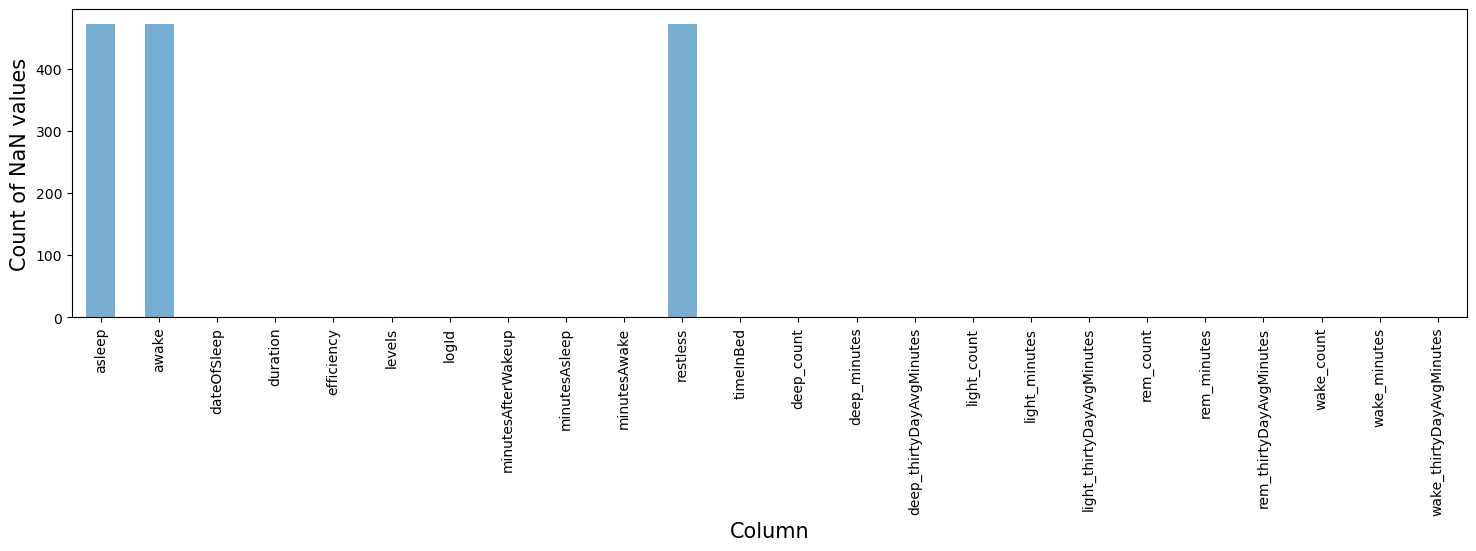

In [40]:
# Check for NA 
df_sleep.isna().sum().plot(kind = 'bar', figsize = (18,4), alpha = 0.6)
plt.xlabel('Column', fontsize = 15)
plt.ylabel('Count of NaN values', fontsize = 15)

From NA graphs, we can see that asleep, awake and restless have Nan values. This is because during data extraction process, either classic (deep, light, rem and awake_ stages are recorded or other stages The sleep level the user entered. The values returned for the sleep log type are: classic: restless | asleep | awake stages: deep | light | rem | wake.

So, we can just drop thes columns.

In [41]:
def finaldata_clean(df_sleep_level):
    drop_columns = ["awake","asleep", "restless", "levels"]
    df_sleep_level.drop(columns= drop_columns, inplace=True)
    return(df_sleep_level)

In [42]:
df_sleep_final = finaldata_clean(df_sleep_level)

Importing final dataset into csv file for later analysis

In [43]:
print(df_sleep.columns.tolist())
df_sleep.to_csv('df_sleepfinal.csv', index=False)

['dateOfSleep', 'duration', 'efficiency', 'logId', 'minutesAfterWakeup', 'minutesAsleep', 'minutesAwake', 'timeInBed', 'deep_count', 'deep_minutes', 'deep_thirtyDayAvgMinutes', 'light_count', 'light_minutes', 'light_thirtyDayAvgMinutes', 'rem_count', 'rem_minutes', 'rem_thirtyDayAvgMinutes', 'wake_count', 'wake_minutes', 'wake_thirtyDayAvgMinutes']
